In [1]:
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive
from torchvision.datasets import Cityscapes, DatasetFolder
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import itertools
from tqdm import tqdm
import os
import cv2
import glob
import pickle
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.datasets import VisionDataset
from PIL import Image
import os
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import Dataset, DataLoader
from skimage import exposure
import torch.nn.functional as F
from torchvision.models import vgg16, VGG16_Weights



if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = torch.device('cpu')
    print('Using CPU')

CITYSCAPES_DIR = '/work/cvcs2024/fiorottandi/workspace/data/cityscapes/'
GTA_DIR = '/work/cvcs2024/fiorottandi/workspace/data/gta/'
CHECKPOINT_DIR = '/work/cvcs2024/fiorottandi/workspace/checkpoints/'
CHECKPOINT_GAN_DIR = '/work/cvcs2024/fiorottandi/workspace/checkpoints/original'
CHECKPOINT_MODIFIED_GAN_DIR = '/work/cvcs2024/fiorottandi/workspace/checkpoints/modified'
RESULTS_GAN_DIR = '/work/cvcs2024/fiorottandi/workspace/results/original'
RESULTS_MODIFIED_GAN_DIR = '/work/cvcs2024/fiorottandi/workspace/results/modified'

#IMAGE_SIZE_X = 224#used to extract the features in the retrieval model
#IMAGE_SIZE_Y = 224

IMAGE_SIZE_X=256 #used to train the models
IMAGE_SIZE_Y=256

BATCH_SIZE = 4
NUM_WORKERS = 1


Using GPU


In [2]:
#Define transformations for input images
input_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE_X, IMAGE_SIZE_Y)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for target images
target_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE_X, IMAGE_SIZE_Y)),
    transforms.ToTensor()
])


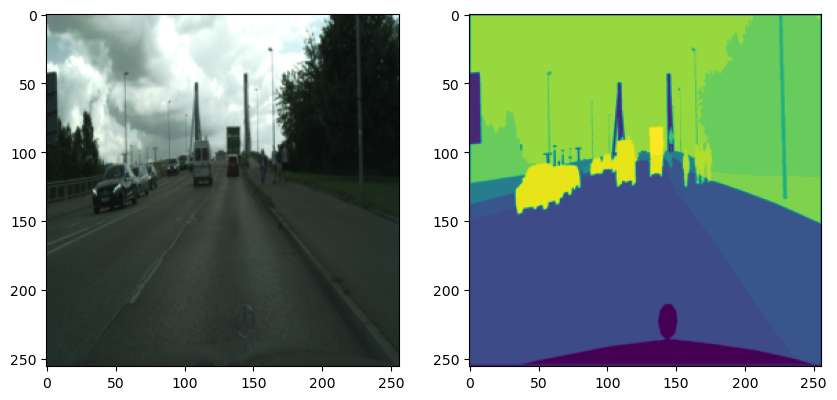

In [3]:
#Download cityscapes dataset and use transformations to resize the images to the right dimension
cityscapes = Cityscapes(CITYSCAPES_DIR, split='train', mode='fine', target_type='semantic', transform=input_transform, target_transform=target_transform)

fix, ax = plt.subplots(1, 2, figsize=(10, 5))
img, target = cityscapes[4]
ax[0].imshow(img.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[1].imshow(target.permute(1, 2, 0))
plt.show()

cityscapes_loader = DataLoader(cityscapes, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

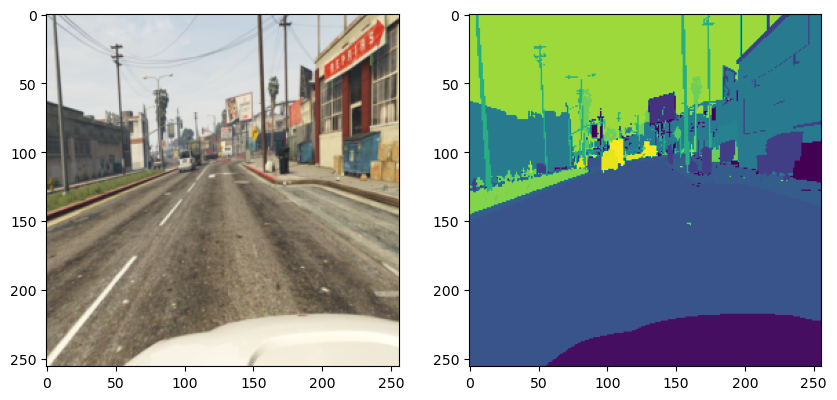

In [4]:
# GTADataset with resize transformations
class GTADataset(VisionDataset):
    def __init__(self, root, transform=None, target_transform=None):
        super(GTADataset, self).__init__(root, transform=transform, target_transform=target_transform)
        self.image_dir = os.path.join(root, 'images')
        self.label_dir = os.path.join(root, 'labels')
        self.images = sorted(os.listdir(self.image_dir))
        self.labels = sorted(os.listdir(self.label_dir))
        assert len(self.images) == len(self.labels), "Mismatch between number of images and labels"

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        label_path = os.path.join(self.label_dir, self.labels[index])
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def __len__(self):
        return len(self.images)

gta = GTADataset(GTA_DIR, transform=input_transform, target_transform=target_transform)

fix, ax = plt.subplots(1, 2, figsize=(10, 5))
img, target = gta[4]
ax[0].imshow(img.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[1].imshow(target.permute(1, 2, 0))
plt.show()

gta_loader = DataLoader(gta, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

/tmp/ipykernel_1309282/3106160925.py:4: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched = exposure.match_histograms(np.array(image), np.array(reference), multichannel=True)


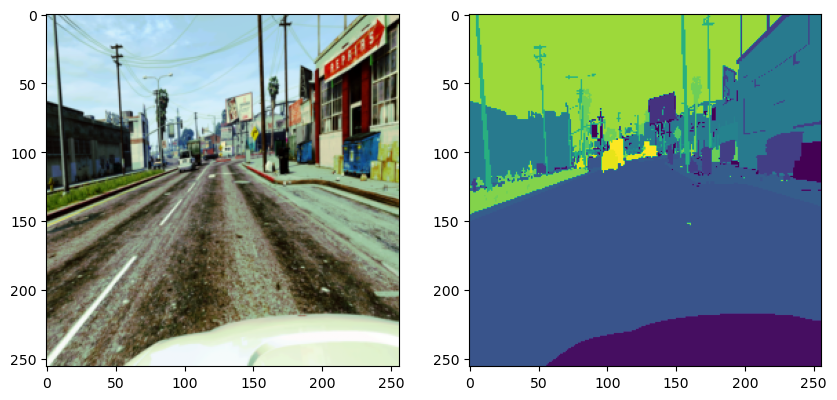

In [5]:
# Define histogram matching function
def match_histogram(image, reference):
    """Match the histogram of the image to the reference image."""
    matched = exposure.match_histograms(np.array(image), np.array(reference), multichannel=True)
    return Image.fromarray(matched)

# Load a few Cityscapes images to use as reference for histogram matching, converting them to RGB
reference_images = [transforms.ToPILImage()(cityscapes[i][0].clone()).convert('RGB') for i in range(10)]

# Define a new GTA dataset class with histogram matching
class GTADatasetWithHistogramMatching(VisionDataset):
    def __init__(self, root, reference_images, transform=None, target_transform=None):
        super(GTADatasetWithHistogramMatching, self).__init__(root, transform=transform, target_transform=target_transform)
        self.image_dir = os.path.join(root, 'images')
        self.label_dir = os.path.join(root, 'labels')
        self.images = sorted(os.listdir(self.image_dir))
        self.labels = sorted(os.listdir(self.label_dir))
        assert len(self.images) == len(self.labels), "Mismatch between number of images and labels"
        self.reference_images = reference_images

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        label_path = os.path.join(self.label_dir, self.labels[index])
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)

        # Apply histogram matching
        reference_image = self.reference_images[index % len(self.reference_images)]
        image = match_histogram(image, reference_image)

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def __len__(self):
        return len(self.images)

# Load GTA dataset with histogram matching
gta_histogram_matched = GTADatasetWithHistogramMatching(GTA_DIR, reference_images, transform=input_transform, target_transform=target_transform)

# Display a sample from GTA after histogram matching
fix, ax = plt.subplots(1, 2, figsize=(10, 5))
img, target = gta_histogram_matched[4]
ax[0].imshow(img.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[1].imshow(target.permute(1, 2, 0))  
plt.show()

# DataLoader for GTA with histogram matching
gta_loader_histogram_matched = DataLoader(gta_histogram_matched, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)


feature extraction with resnet

In [6]:
'''
from torchvision.models import resnet18

# Load pre-trained ResNet18 model and move it to the device (GPU)
model = resnet18(pretrained=True).to(device).eval()

def extract_features(data_loader, model, device):
    features = []
    with torch.no_grad():
        for imgs, _ in tqdm(data_loader):
            imgs = imgs.to(device)  # Move images to the GPU
            feats = model(imgs).view(imgs.size(0), -1)
            feats = F.normalize(feats, dim=1)
            features.append(feats.cpu().numpy())  # Move back to CPU before storing to save memory
    return np.concatenate(features, axis=0)

# Extract features for Cityscapes and GTA datasets
cityscapes_features = extract_features(cityscapes_loader, model, device)
gta_features = extract_features(gta_loader_histogram_matched, model, device)

# Calculate cosine similarity in smaller batches to save memory
batch_size = 100  # Adjust this size based on your memory capacity
gta_to_cityscapes = []

for i in tqdm(range(0, gta_features.shape[0], batch_size)):
    end_i = min(i + batch_size, gta_features.shape[0])
    # Compute cosine similarity on CPU to avoid GPU memory overflow
    similarities = cosine_similarity(gta_features[i:end_i], cityscapes_features)
    gta_to_cityscapes.extend(np.argmax(similarities, axis=1))

# Save the paired indices
with open('/work/cvcs2024/fiorottandi/workspace/gta_to_cityscapes.pkl', 'wb') as f:
    pickle.dump(gta_to_cityscapes, f)

print('Paired dataset saved to /work/cvcs2024/fiorottandi/workspace/gta_to_cityscapes.pkl')'''

"\nfrom torchvision.models import resnet18\n\n# Load pre-trained ResNet18 model and move it to the device (GPU)\nmodel = resnet18(pretrained=True).to(device).eval()\n\ndef extract_features(data_loader, model, device):\n    features = []\n    with torch.no_grad():\n        for imgs, _ in tqdm(data_loader):\n            imgs = imgs.to(device)  # Move images to the GPU\n            feats = model(imgs).view(imgs.size(0), -1)\n            feats = F.normalize(feats, dim=1)\n            features.append(feats.cpu().numpy())  # Move back to CPU before storing to save memory\n    return np.concatenate(features, axis=0)\n\n# Extract features for Cityscapes and GTA datasets\ncityscapes_features = extract_features(cityscapes_loader, model, device)\ngta_features = extract_features(gta_loader_histogram_matched, model, device)\n\n# Calculate cosine similarity in smaller batches to save memory\nbatch_size = 100  # Adjust this size based on your memory capacity\ngta_to_cityscapes = []\n\nfor i in tqdm(r

feature extraction with dinov2

In [7]:
'''
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import torchvision.transforms as T

# Load the DINOv2 processor and model
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-small')
model = AutoModel.from_pretrained('facebook/dinov2-small').eval().to(device)

# Assuming these are the mean and std used for normalization
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

def denormalize(imgs):
    return imgs * std + mean

def extract_features(data_loader, model, processor, device):
    features = []
    with torch.no_grad():
        for imgs, _ in tqdm(data_loader):
            # Denormalize images before processing
            imgs = denormalize(imgs)
            # Preprocess images using the processor
            inputs = processor(images=imgs, return_tensors="pt").to(device)
            # Extract features
            outputs = model(**inputs)
            last_hidden_states = outputs.last_hidden_state
            # Flatten and normalize the features
            feats = last_hidden_states.mean(dim=1).view(imgs.size(0), -1)
            feats = torch.nn.functional.normalize(feats, dim=1)
            features.append(feats.cpu().numpy())  # Move back to CPU before storing to save memory
    return np.concatenate(features, axis=0)


# Extract features for Cityscapes and GTA datasets
cityscapes_features = extract_features(cityscapes_loader, model, processor, device)
gta_features = extract_features(gta_loader_histogram_matched, model, processor, device)'''

'\nfrom transformers import AutoImageProcessor, AutoModel\nfrom PIL import Image\nimport torch\nfrom tqdm import tqdm\nimport numpy as np\nfrom sklearn.metrics.pairwise import cosine_similarity\nimport pickle\nimport torchvision.transforms as T\n\n# Load the DINOv2 processor and model\nprocessor = AutoImageProcessor.from_pretrained(\'facebook/dinov2-small\')\nmodel = AutoModel.from_pretrained(\'facebook/dinov2-small\').eval().to(device)\n\n# Assuming these are the mean and std used for normalization\nmean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)\nstd = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)\n\ndef denormalize(imgs):\n    return imgs * std + mean\n\ndef extract_features(data_loader, model, processor, device):\n    features = []\n    with torch.no_grad():\n        for imgs, _ in tqdm(data_loader):\n            # Denormalize images before processing\n            imgs = denormalize(imgs)\n            # Preprocess images using the processor\n            inputs = 

In [8]:
'''# Calculate cosine similarity in smaller batches to save memory
batch_size = 100  # Adjust this size based on your memory capacity
gta_to_cityscapes = []

for i in tqdm(range(0, gta_features.shape[0], batch_size)):
    end_i = min(i + batch_size, gta_features.shape[0])
    # Compute cosine similarity on CPU to avoid GPU memory overflow
    similarities = cosine_similarity(gta_features[i:end_i], cityscapes_features)
    gta_to_cityscapes.extend(np.argmax(similarities, axis=1))

# Save the paired indices
with open('/work/cvcs2024/fiorottandi/workspace/dinov2_gta_to_cityscapes.pkl', 'wb') as f:
    pickle.dump(gta_to_cityscapes, f)
'''

print('Paired dataset saved to /work/cvcs2024/fiorottandi/workspace/dinov2_gta_to_cityscapes.pkl')

Paired dataset saved to /work/cvcs2024/fiorottandi/workspace/dinov2_gta_to_cityscapes.pkl


In [9]:
'''
#indexes created with RESNET
with open('/work/cvcs2024/fiorottandi/workspace/gta_to_cityscapes.pkl', 'rb') as f:
    gta_to_cityscapes = pickle.load(f) # A list or array that maps each GTA image (index) to the most similar Cityscapes image 
'''

#indexes created with DINOV2
with open('/work/cvcs2024/fiorottandi/workspace/dinov2_gta_to_cityscapes.pkl', 'rb') as f:
    gta_to_cityscapes = pickle.load(f) # A list or array that maps each GTA image (index) to the most similar Cityscapes image 

Paired dataset for MODIFIED MODEL (has images and segmentations)

/tmp/ipykernel_1309282/3106160925.py:4: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched = exposure.match_histograms(np.array(image), np.array(reference), multichannel=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


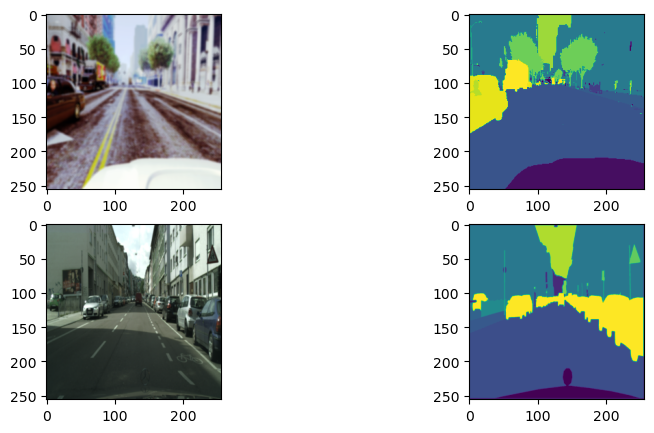

In [10]:
# Custom dataset class for paired GTA and Cityscapes images, with option to aplly the Bilateral Filter operator on gta for noise reduction
class PairedDataset(Dataset):
    def __init__(self, gta_dataset, cityscapes_dataset, gta_to_cityscapes, apply_bilateral=False):
        self.gta_dataset = gta_dataset
        self.cityscapes_dataset = cityscapes_dataset
        self.gta_to_cityscapes = gta_to_cityscapes
        self.apply_bilateral = apply_bilateral

    def __len__(self):
        return len(self.gta_to_cityscapes)

    def __getitem__(self, idx):
        gta_img, gta_seg = self.gta_dataset[idx]
        cityscapes_img, cityscapes_seg = self.cityscapes_dataset[self.gta_to_cityscapes[idx]]

        # Apply bilateral filtering if enabled
        if self.apply_bilateral:
            gta_img = self.apply_bilateral_filtering(gta_img)

        return gta_img, gta_seg, cityscapes_img, cityscapes_seg

    def apply_bilateral_filtering(self, image):
        # Convert torch tensor to numpy array, apply filtering, then convert back to tensor
        image_np = image.permute(1, 2, 0).numpy()
        filtered_image = cv2.bilateralFilter(image_np, d=5, sigmaColor=25, sigmaSpace=25)
        return torch.from_numpy(filtered_image).permute(2, 0, 1)

# Create the paired dataset
paired_dataset = PairedDataset(gta_histogram_matched, cityscapes, gta_to_cityscapes, apply_bilateral=True)
fix, ax = plt.subplots(2, 2, figsize=(10, 5))
i = 338
ax[0][0].imshow(paired_dataset[i][0].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[0][1].imshow(paired_dataset[i][1].permute(1, 2, 0))
ax[1][0].imshow(paired_dataset[i][2].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[1][1].imshow(paired_dataset[i][3].permute(1, 2, 0))
plt.show()

DataLoaders created: Perspective transformations applied to the training set only.


/tmp/ipykernel_1309282/3106160925.py:4: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched = exposure.match_histograms(np.array(image), np.array(reference), multichannel=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GTA Image Shape: torch.Size([3, 256, 256])
Cityscapes Image Shape: torch.Size([3, 256, 256])


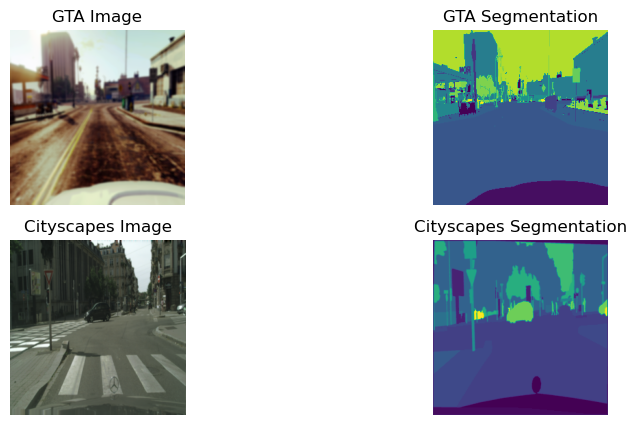

In [11]:
#divide into train and test set, apply random perspective transformations to the train set, create train and test dataloaders
import random
from torch.utils.data import Subset
import torchvision.transforms.functional as TF

# Normalization and denormalization constants
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

# split the dataset, mantaining the correspondece of the pairs
def split_dataset(paired_dataset, split_ratio=0.8):
    total_size = len(paired_dataset)
    indices = list(range(total_size))
    split = int(split_ratio * total_size)
    random.shuffle(indices)
    train_indices, test_indices = indices[:split], indices[split:]
    return train_indices, test_indices

# define the Perspective Transformation
class RandomPerspectiveTransform:
    def __init__(self, distortion_scale=0.2, p=0.5):  # Reduced distortion_scale
        self.distortion_scale = distortion_scale
        self.p = p

    def __call__(self, sample):
        image_gta, label_gta, image_cityscapes, label_cityscapes = sample

        if random.random() < self.p:
            # Apply the same transformation to all images in the sample
            width, height = image_gta.shape[2], image_gta.shape[1]
            startpoints, endpoints = self.get_random_perspective_params(width, height)
            
            # Convert tensors to NumPy arrays
            image_gta_np = image_gta.permute(1, 2, 0).numpy()
            label_gta_np = label_gta.squeeze().numpy()  # Assuming label_gta is single-channel
            image_cityscapes_np = image_cityscapes.permute(1, 2, 0).numpy()
            label_cityscapes_np = label_cityscapes.squeeze().numpy()  # Assuming label_cityscapes is single-channel

            # Convert startpoints and endpoints to NumPy format
            startpoints = np.float32(startpoints)
            endpoints = np.float32(endpoints)
            
            # Compute the perspective transformation matrix
            matrix_gta = cv2.getPerspectiveTransform(startpoints, endpoints)
            matrix_cityscapes = cv2.getPerspectiveTransform(startpoints, endpoints)
            
            # Apply perspective transformation using OpenCV
            image_gta_np = cv2.warpPerspective(image_gta_np, matrix_gta, (width, height), flags=cv2.INTER_CUBIC)
            image_cityscapes_np = cv2.warpPerspective(image_cityscapes_np, matrix_cityscapes, (width, height), flags=cv2.INTER_CUBIC)
            
            # Segmentation maps
            matrix_label_gta = cv2.getPerspectiveTransform(startpoints, endpoints)
            matrix_label_cityscapes = cv2.getPerspectiveTransform(startpoints, endpoints)
            
            label_gta_np = cv2.warpPerspective(label_gta_np, matrix_label_gta, (width, height), flags=cv2.INTER_NEAREST)
            label_cityscapes_np = cv2.warpPerspective(label_cityscapes_np, matrix_label_cityscapes, (width, height), flags=cv2.INTER_NEAREST)

            # Convert NumPy arrays back to tensors
            image_gta = torch.tensor(image_gta_np).permute(2, 0, 1)
            image_cityscapes = torch.tensor(image_cityscapes_np).permute(2, 0, 1)
            label_gta = torch.tensor(label_gta_np).unsqueeze(0)  # Adding the channel dimension back
            label_cityscapes = torch.tensor(label_cityscapes_np).unsqueeze(0)  # Adding the channel dimension back

        return image_gta, label_gta, image_cityscapes, label_cityscapes

    def get_random_perspective_params(self, width, height):
        half_height = height // 2
        half_width = width // 2

        # Reduce the range of distortion
        topleft = (random.randint(0, int(self.distortion_scale * half_width)),
                   random.randint(0, int(self.distortion_scale * half_height)))
        topright = (random.randint(width - int(self.distortion_scale * half_width) - 1, width - 1),
                    random.randint(0, int(self.distortion_scale * half_height)))
        botright = (random.randint(width - int(self.distortion_scale * half_width) - 1, width - 1),
                    random.randint(height - int(self.distortion_scale * half_height) - 1, height - 1))
        botleft = (random.randint(0, int(self.distortion_scale * half_width)),
                   random.randint(height - int(self.distortion_scale * half_height) - 1, height - 1))

        startpoints = [(0, 0), (width, 0), (width, height), (0, height)]
        endpoints = [topleft, topright, botright, botleft]

        return startpoints, endpoints

    
#split the dataset
train_indices, test_indices = split_dataset(paired_dataset)

train_dataset = Subset(paired_dataset, train_indices)
test_dataset = Subset(paired_dataset, test_indices)

# Apply the random transformation to the train set (p=probability of the sample to be transformed or not)
perspective_transform = RandomPerspectiveTransform(distortion_scale=0.2, p=0.5)

class DatasetWithPerspective(Dataset):
    def __init__(self, paired_dataset, indices, perspective_transform=None):
        self.paired_dataset = paired_dataset
        self.indices = indices
        self.perspective_transform = perspective_transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        gta_img, gta_seg, cityscapes_img, cityscapes_seg = self.paired_dataset[actual_idx]

        if self.perspective_transform:
            gta_img, gta_seg, cityscapes_img, cityscapes_seg = self.perspective_transform(
                (gta_img, gta_seg, cityscapes_img, cityscapes_seg))
        
        return gta_img, gta_seg, cityscapes_img, cityscapes_seg

train_dataset_with_perspective = DatasetWithPerspective(
    paired_dataset=paired_dataset,
    indices=train_indices,
    perspective_transform=perspective_transform
)

# create train and test dataloaders
train_loader = DataLoader(train_dataset_with_perspective, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)


print('DataLoaders created: Perspective transformations applied to the training set only.')

#random sample from the transformed training dataset


def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    return image


def show_sample(sample):
    gta_img, gta_seg, cityscapes_img, cityscapes_seg = sample
    print(f"GTA Image Shape: {gta_img.shape}")
    print(f"Cityscapes Image Shape: {cityscapes_img.shape}")
    
    gta_img_np = denormalize(gta_img.permute(1, 2, 0).numpy())
    cityscapes_img_np = denormalize(cityscapes_img.permute(1, 2, 0).numpy())

    
    gta_seg_np = gta_seg.permute(1, 2, 0).numpy()
    cityscapes_seg_np = cityscapes_seg.permute(1, 2, 0).numpy()

    
    fig, axes = plt.subplots(2, 2, figsize=(10, 5))
    axes[0, 0].imshow(gta_img_np)
    axes[0, 0].set_title("GTA Image")
    axes[0, 1].imshow(gta_seg_np)
    axes[0, 1].set_title("GTA Segmentation")
    axes[1, 0].imshow(cityscapes_img_np)
    axes[1, 0].set_title("Cityscapes Image")
    axes[1, 1].imshow(cityscapes_seg_np)
    axes[1, 1].set_title("Cityscapes Segmentation")

    for ax in axes.flatten():
        ax.axis('off')

    plt.show()

train_iter = iter(train_loader)
sample = next(train_iter)

show_sample((sample[0][0], sample[1][0], sample[2][0], sample[3][0]))


Paired dataset for ORIGINAL MODEL (doesn't have the segmentations)

/tmp/ipykernel_1309282/3106160925.py:4: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched = exposure.match_histograms(np.array(image), np.array(reference), multichannel=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


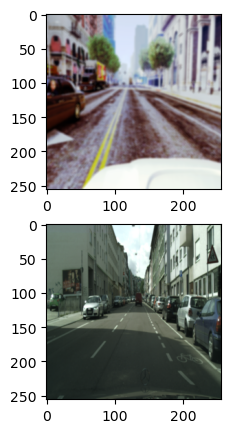

DataLoaders created: Perspective transformations applied to the training set only.
sample from train set


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


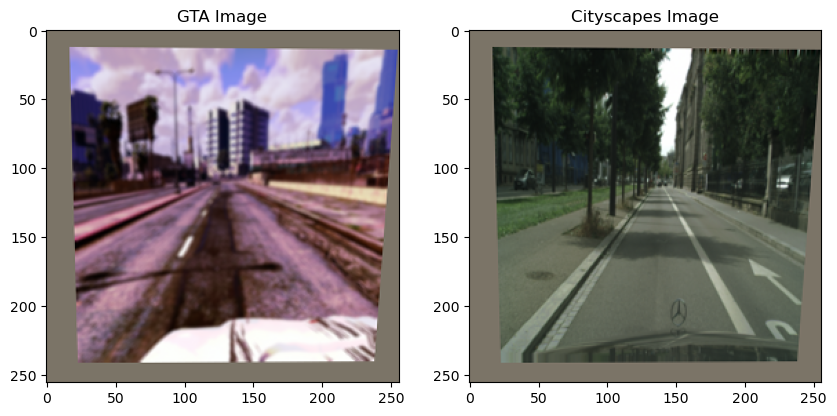

sample from test set


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


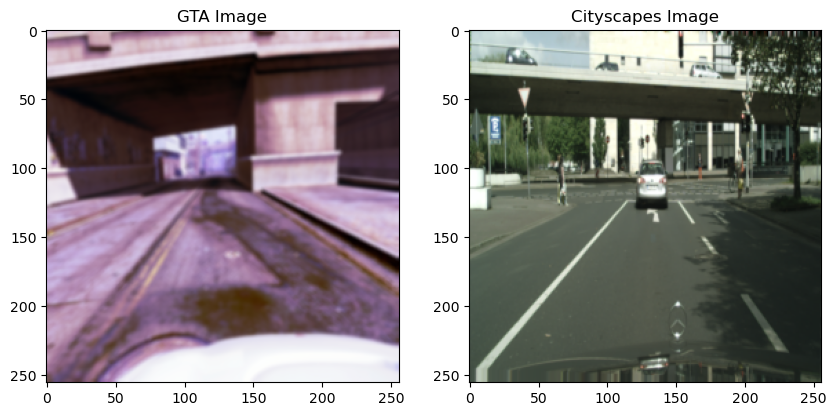

In [12]:
class PairedDatasetNoSegm(Dataset):
    def __init__(self, gta_dataset, cityscapes_dataset, gta_to_cityscapes, apply_bilateral=False):
        self.gta_dataset = gta_dataset
        self.cityscapes_dataset = cityscapes_dataset
        self.gta_to_cityscapes = gta_to_cityscapes
        self.apply_bilateral = apply_bilateral

    def __len__(self):
        return len(self.gta_to_cityscapes)

    def __getitem__(self, idx):
        gta_img, _ = self.gta_dataset[idx]  # Ignore segmentation
        cityscapes_img, _ = self.cityscapes_dataset[self.gta_to_cityscapes[idx]]

        # Apply bilateral filtering if enabled
        if self.apply_bilateral:
            gta_img = self.apply_bilateral_filtering(gta_img)

        return gta_img, cityscapes_img

    def apply_bilateral_filtering(self, image):
        # Convert torch tensor to numpy array, apply filtering, then convert back to tensor
        image_np = image.permute(1, 2, 0).numpy()
        filtered_image = cv2.bilateralFilter(image_np, d=5, sigmaColor=25, sigmaSpace=25)
        return torch.from_numpy(filtered_image).permute(2, 0, 1)

# Create the paired dataset
paired_dataset_nosegm = PairedDatasetNoSegm(gta_histogram_matched, cityscapes, gta_to_cityscapes, apply_bilateral=True)
fix, ax = plt.subplots(2, 1, figsize=(10, 5))
i = 338
ax[0].imshow(paired_dataset_nosegm[i][0].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[1].imshow(paired_dataset_nosegm[i][1].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
plt.show()


#divide into train and test set, apply random perspective transformations to the train set, create train and test dataloaders

class RandomPerspectiveTransformNoSegm:
    def __init__(self, distortion_scale=0.2, p=0.5):  # Reduced distortion_scale
        self.distortion_scale = distortion_scale
        self.p = p

    def __call__(self, sample):
        image_gta, image_cityscapes = sample

        if random.random() < self.p:
            # Apply the same transformation to all images in the sample
            width, height = image_gta.shape[2], image_gta.shape[1]
            startpoints, endpoints = self.get_random_perspective_params(width, height)
            
            # Convert tensors to NumPy arrays
            image_gta_np = image_gta.permute(1, 2, 0).numpy()
            image_cityscapes_np = image_cityscapes.permute(1, 2, 0).numpy()
            
            # Convert startpoints and endpoints to NumPy format
            startpoints = np.float32(startpoints)
            endpoints = np.float32(endpoints)
            
            # Compute the perspective transformation matrix
            matrix_gta = cv2.getPerspectiveTransform(startpoints, endpoints)
            matrix_cityscapes = cv2.getPerspectiveTransform(startpoints, endpoints)
            
            # Apply perspective transformation using OpenCV
            image_gta_np = cv2.warpPerspective(image_gta_np, matrix_gta, (width, height), flags=cv2.INTER_CUBIC)
            image_cityscapes_np = cv2.warpPerspective(image_cityscapes_np, matrix_cityscapes, (width, height), flags=cv2.INTER_CUBIC)
            
            # Convert NumPy arrays back to tensors
            image_gta = torch.tensor(image_gta_np).permute(2, 0, 1)
            image_cityscapes = torch.tensor(image_cityscapes_np).permute(2, 0, 1)
                    
        return image_gta, image_cityscapes

    def get_random_perspective_params(self, width, height):
        half_height = height // 2
        half_width = width // 2

        # Reduce the range of distortion
        topleft = (random.randint(0, int(self.distortion_scale * half_width)),
                   random.randint(0, int(self.distortion_scale * half_height)))
        topright = (random.randint(width - int(self.distortion_scale * half_width) - 1, width - 1),
                    random.randint(0, int(self.distortion_scale * half_height)))
        botright = (random.randint(width - int(self.distortion_scale * half_width) - 1, width - 1),
                    random.randint(height - int(self.distortion_scale * half_height) - 1, height - 1))
        botleft = (random.randint(0, int(self.distortion_scale * half_width)),
                   random.randint(height - int(self.distortion_scale * half_height) - 1, height - 1))

        startpoints = [(0, 0), (width, 0), (width, height), (0, height)]
        endpoints = [topleft, topright, botright, botleft]

        return startpoints, endpoints

    
#split the dataset
train_indices_nosegm, test_indices_nosegm = split_dataset(paired_dataset_nosegm)

# Apply the random transformation to the train set (p=probability of the sample to be transformed or not)
perspective_transform_nosegm = RandomPerspectiveTransformNoSegm(distortion_scale=0.2, p=0.5)

class DatasetWithPerspectiveNoSegm(Dataset):
    def __init__(self, paired_dataset, indices, perspective_transform=None):
        self.paired_dataset = paired_dataset
        self.indices = indices
        self.perspective_transform = perspective_transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        gta_img, cityscapes_img= self.paired_dataset[actual_idx]

        if self.perspective_transform:
            gta_img, cityscapes_img= self.perspective_transform((gta_img, cityscapes_img))

        return {'A':gta_img, 
                'B':cityscapes_img,
                 #'A_paths': f'dummy_path_A_{idx}',  # Dummy path for 'A'
                 #'B_paths': f'dummy_path_B_{idx}'   # Dummy path for 'B'
                }

train_dataset_nosegm= DatasetWithPerspectiveNoSegm(
    paired_dataset=paired_dataset_nosegm,
    indices=train_indices_nosegm,
    perspective_transform=perspective_transform_nosegm
)

test_dataset_nosegm = DatasetWithPerspectiveNoSegm(
    paired_dataset=paired_dataset_nosegm,
    indices=test_indices_nosegm,
    perspective_transform=None
)

'''
fix, ax = plt.subplots(2, 1, figsize=(10, 5))
i = 3
ax[0].imshow(train_dataset_nosegm[i]['A'].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[1].imshow(train_dataset_nosegm[i]['B'].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
plt.show()
'''

# create train and test dataloaders
train_loader_nosegm = DataLoader(train_dataset_nosegm, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_loader_nosegm = DataLoader(test_dataset_nosegm, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

print('DataLoaders created: Perspective transformations applied to the training set only.')

#random sample from the transformed training dataset
def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    return image


def show_sample(sample):
    # 'sample' is a dictionary= batch of the images
    gta_imgs = sample['A']
    cityscapes_imgs = sample['B']
    
    # Visualize only the first example of the batch
    gta_img = gta_imgs[0]
    cityscapes_img = cityscapes_imgs[0]
    
    
    gta_img_np = denormalize(gta_img.permute(1, 2, 0).numpy())
    cityscapes_img_np = denormalize(cityscapes_img.permute(1, 2, 0).numpy())
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(gta_img_np)
    axes[0].set_title("GTA Image")
    
    axes[1].imshow(cityscapes_img_np)
    axes[1].set_title("Cityscapes Image")
   
    
    plt.show()

# Extract a sample from the DataLoader and show it
print('sample from train set')
train_iter = iter(train_loader_nosegm)
sample = next(train_iter)
show_sample(sample)

print('sample from test set')
train_iter = iter(test_loader_nosegm)
sample = next(train_iter)
show_sample(sample)


In [13]:
# example of code for saving
output_dir_A = '/homes/fmorandi/cv_project/workspace/data/A'
output_dir_B = '/homes/fmorandi/cv_project/workspace/data/B'
os.makedirs(output_dir_A, exist_ok=True)
os.makedirs(output_dir_B, exist_ok=True)

def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image * 255, 0, 255).astype('uint8')  # Ensure correct range and dtype
    return image

def save_images_from_dataset(dataset):
    for i in range(2):
        # Get the image pair
        sample = dataset[i]
        gta_img = denormalize(sample['A'].permute(1, 2, 0).numpy())
        cityscapes_img = denormalize(sample['B'].permute(1, 2, 0).numpy())
       

        # Save the images using OpenCV
        gta_path = os.path.join(output_dir_A, f'{i}.jpg')
        cityscapes_path = os.path.join(output_dir_B, f'{i}.jpg')

        # Convert RGB to BGR for OpenCV and save
        cv2.imwrite(gta_path, cv2.cvtColor(gta_img, cv2.COLOR_RGB2BGR))
        cv2.imwrite(cityscapes_path, cv2.cvtColor(cityscapes_img, cv2.COLOR_RGB2BGR))

# Save images from the training dataset
save_images_from_dataset(test_dataset_nosegm)




/tmp/ipykernel_1309282/3106160925.py:4: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched = exposure.match_histograms(np.array(image), np.array(reference), multichannel=True)


In [14]:
import os
import cv2
import torch
#code for putting the datasets into the right directories as pix2pix wants
'''
/work/cvcs2024/fiorottandi/workspace/data/dinov2_dataset/
├── A/
│   ├── train/
│   └── test/
└── B/
    ├── train/
    └── test/

    
con comando: srun -Q --immediate=10 --partition=all_serial --gres=gpu:1 --account=cvcs2024 --time 120:00 --pty python /homes/fmorandi/cv_project/pytorch-CycleGAN-and-pix2pix/datasets/combine_A_and_B.py  --fold_A /work/cvcs2024/fiorottandi/workspace/data/dinov2_dataset/A --fold_B /work/cvcs2024/fiorottandi/workspace/data/dinov2_dataset/B --fold_AB /work/cvcs2024/fiorottandi/workspace/data/dinov2_dataset/combinedAB
dataset finale per pix2pix:
/work/cvcs2024/fiorottandi/workspace/data/dinov2_dataset/combinedAB


(in /work/cvcs2024/fiorottandi/workspace/data/dataset/combinedAB c'è il dataset creato usando la resnet come retrieval)
'''
'''
# Define the paths
output_dir_A = '/work/cvcs2024/fiorottandi/workspace/data/dinov2_dataset/A'
output_dir_B = '/work/cvcs2024/fiorottandi/workspace/data/dinov2_dataset/B'

def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image * 255, 0, 255).astype('uint8')  # Ensure correct range and dtype
    return image

def save_images_from_dataset(dataset, phase):
    for i in range(len(dataset)):
        # Get the image pair
        sample = dataset[i]
        gta_img = denormalize(sample['A'].permute(1, 2, 0).numpy())  
        cityscapes_img = denormalize(sample['B'].permute(1, 2, 0).numpy())

        # Save the images using OpenCV
        gta_path = os.path.join(output_dir_A, phase, f'{i}.jpg')
        cityscapes_path = os.path.join(output_dir_B, phase, f'{i}.jpg')

        # Convert RGB to BGR for OpenCV and save
        cv2.imwrite(gta_path, cv2.cvtColor(gta_img, cv2.COLOR_RGB2BGR))
        cv2.imwrite(cityscapes_path, cv2.cvtColor(cityscapes_img, cv2.COLOR_RGB2BGR))

# Save images from the training dataset
save_images_from_dataset(train_dataset_nosegm, 'train')

# Save images from the test dataset
save_images_from_dataset(test_dataset_nosegm, 'test')
'''


/tmp/ipykernel_1309282/3106160925.py:4: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched = exposure.match_histograms(np.array(image), np.array(reference), multichannel=True)


In [15]:
'''
import sys
sys.path.append(os.path.join(os.getcwd(), 'pytorch-CycleGAN-and-pix2pix'))
import torch
from models import create_model
from util.visualizer import Visualizer
import time

# Imposta le opzioni di training manualmente (modifica secondo le tue esigenze)
class Options:
    def __init__(self):
        self.name = 'pix2pix_experiment'
        self.model = 'pix2pix'
        self.netG = 'unet_256'
        self.dataset_mode = 'aligned'
        self.dataroot = './datasets/your_dataset_directory'
        self.direction = 'AtoB'
        self.n_epochs = 1
        self.n_epochs_decay = 1
        self.lr = 0.0002
        self.beta1 = 0.5
        self.lambda_L1 = 100.0
        self.gan_mode = 'vanilla'
        self.save_epoch_freq = 10
        self.batch_size = 4  # Assicurati che questo corrisponda al batch size usato nel DataLoader
        self.display_freq = 1000
        self.print_freq = 1000
        self.epoch_count = 1  # Inizia dal primo epoch
        self.num_threads = 1  # Numero di thread (workers) per DataLoader
        self.gpu_ids = [0] if torch.cuda.is_available() else []
        self.isTrain = True
        self.checkpoints_dir = CHECKPOINT_GAN_DIR
        self.preprocess = 'resize_and_crop'
        self.n_layers_D = 3  # Default value for PatchGAN discriminator
        self.load_iter = 0
        self.continue_train = False
        self.epoch = 0  # Current epoch
        self.verbose = True  # Add this attribute for logging verbosity

        # Aggiungi attributi necessari per il modello e la visualizzazione
        self.input_nc = 3  # Numero di canali di input (es. RGB immagini)
        self.output_nc = 3  # Numero di canali di output (es. RGB immagini)
        self.ngf = 64  # Numero di feature maps nel generatore
        self.ndf = 64  # Numero di feature maps nel discriminatore
        self.norm = 'batch'  # Normalizzazione, può essere 'batch', 'instance', o 'none'
        self.no_dropout = False  # Se True, non applica dropout
        self.init_type = 'normal'  # Tipo di inizializzazione dei pesi
        self.init_gain = 0.02  # Guadagno di inizializzazione
        self.netD = 'basic'  # Tipo di discriminatore, può essere 'basic', 'n_layers', o 'pixel'
        self.lr_policy = 'step'  # Politica di learning rate, può essere 'linear', 'step', 'plateau', 'lambda', etc.
        self.lr_decay_iters = 10  # Per lr_policy='step', il numero di iterazioni per la diminuzione
        self.lr_step = 10  # Per lr_policy='step', il passo per la diminuzione
        
        # Aggiungi attributi per il visualizzatore
        self.display_id = 1  # ID della finestra di visualizzazione
        self.display_winsize = 256  # Dimensione della finestra di visualizzazione
        self.display_env = 'main'  # Ambiente di visualizzazione per visdom
        self.display_ncols = 0  # Numero di colonne nel visualizzatore
        self.no_html = False  # Se True, non salva le immagini HTML
        self.update_html_freq = 1000  # Frequenza per l'aggiornamento HTML
        self.display_port = 8097  # Porta per la visualizzazione tramite visdom
        self.display_server = 'http://localhost'  # Server per visdom

        # Aggiungi attributi opzionali per l'integrazione con strumenti come wandb
        self.use_wandb = False  # Se True, usa wandb per il tracking
        self.wandb_project = 'pix2pix'  # Nome del progetto wandb
        self.wandb_name = 'experiment'  # Nome dell'esperimento wandb
        self.wandb_project_name = 'pix2pix'  # Nome del progetto wandb

opt = Options()

# Crea e configura il modello Pix2Pix
model = create_model(opt)  # Crea il modello Pix2Pix
model.setup(opt)           # Configura il modello

# Configura il visualizer
visualizer = Visualizer(opt)
total_iters = 0            # Conta il numero totale di iterazioni

# Ciclo di training
for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):
    epoch_start_time = time.time()  # Inizia a contare il tempo
    iter_data_time = time.time()    # Inizia a contare il tempo per la lettura dei dati
    epoch_iter = 0                  # Conta le iterazioni per ogni epoca
    
    # Utilizza tqdm per visualizzare la barra di avanzamento
    for i, data in enumerate(tqdm(train_loader_nosegm, desc=f"Epoch {epoch}/{opt.n_epochs + opt.n_epochs_decay}", unit="batch")):
        iter_start_time = time.time()  # Tempo per ciascuna iterazione
        total_iters += opt.batch_size
        epoch_iter += opt.batch_size
        model.set_input(data)  # Imposta i dati di input
        model.optimize_parameters()  # Ottimizza i parametri del modello
        
        if total_iters % opt.display_freq == 0:  # Visualizza i risultati
            visualizer.display_current_results(model.get_current_visuals(), epoch, save_result=False)

        if total_iters % opt.print_freq == 0:    # Stampa le perdite
            losses = model.get_current_losses()
            t_comp = (time.time() - iter_start_time) / opt.batch_size
            visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, iter_data_time)

        iter_data_time = time.time()
    
    if epoch % opt.save_epoch_freq == 0:  # Salva il modello
        print(f'Salvataggio del modello all\'epoca {epoch}')
        model.save_networks(epoch)
    
    # Aggiorna la learning rate
    if hasattr(model, 'schedulers') and model.schedulers:
        for scheduler in model.schedulers:
            scheduler.step()  # Usa il metodo step() per aggiornare la learning rate
    else:
        print("No learning rate scheduler found. Skipping learning rate update.")

    print(f'Epoca {epoch} completata in {time.time() - epoch_start_time} secondi.')

print('Training completo.')
'''

'\nimport sys\nsys.path.append(os.path.join(os.getcwd(), \'pytorch-CycleGAN-and-pix2pix\'))\nimport torch\nfrom models import create_model\nfrom util.visualizer import Visualizer\nimport time\n\n# Imposta le opzioni di training manualmente (modifica secondo le tue esigenze)\nclass Options:\n    def __init__(self):\n        self.name = \'pix2pix_experiment\'\n        self.model = \'pix2pix\'\n        self.netG = \'unet_256\'\n        self.dataset_mode = \'aligned\'\n        self.dataroot = \'./datasets/your_dataset_directory\'\n        self.direction = \'AtoB\'\n        self.n_epochs = 1\n        self.n_epochs_decay = 1\n        self.lr = 0.0002\n        self.beta1 = 0.5\n        self.lambda_L1 = 100.0\n        self.gan_mode = \'vanilla\'\n        self.save_epoch_freq = 10\n        self.batch_size = 4  # Assicurati che questo corrisponda al batch size usato nel DataLoader\n        self.display_freq = 1000\n        self.print_freq = 1000\n        self.epoch_count = 1  # Inizia dal primo 